In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

import warnings
warnings.filterwarnings('ignore')

In [11]:
#cargar datos desde archivo csv
r = "dataset_alpha_betha.csv"
datos = pd.read_csv(r, sep=",")

# **Estadistica descriptiva**

In [12]:
datos.head()

,autoID,SeniorCity,Partner,Dependents,Service1,Service2,Security,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,Charges,Demand,Class
0,7590-VHVEG,0,Yes,No,No,No phone service,No,Yes,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,Alpha
1,5575-GNVDE,0,No,No,Yes,No,Yes,No,Yes,No,One year,No,Mailed check,56.95,1889.5,Alpha
2,3668-QPYBK,0,No,No,Yes,No,Yes,Yes,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Betha
3,7795-CFOCW,0,No,No,No,No phone service,Yes,No,Yes,Yes,One year,No,Bank transfer (automatic),42.30,1840.75,Alpha
4,9237-HQITU,0,No,No,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Betha


In [13]:
#informacion de dataframe
datos.info() # 15 caracteristicas- 1 varible objetivo(class)-7043 registros- Sin registros nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   autoID            7043 non-null   object 
 1   SeniorCity        7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   Service1          7043 non-null   object 
 5   Service2          7043 non-null   object 
 6   Security          7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  Contract          7043 non-null   object 
 11  PaperlessBilling  7043 non-null   object 
 12  PaymentMethod     7043 non-null   object 
 13  Charges           7043 non-null   float64
 14  Demand            7043 non-null   object 
 15  Class             7043 non-null   object 
dtypes: float64(1), int64(1), object(14)
memory

In [14]:
datos.isna().sum().sort_values()

autoID              0
SeniorCity          0
Partner             0
Dependents          0
Service1            0
Service2            0
Security            0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
Contract            0
PaperlessBilling    0
PaymentMethod       0
Charges             0
Demand              0
Class               0
dtype: int64

In [15]:
#covertir feature Demand a numerico y SeniorCity a str
datos['Demand'] =datos['Demand'].apply(lambda x: x.replace(' ','0'))
datos['Demand']= pd.to_numeric(datos['Demand'])
datos.SeniorCity = datos.SeniorCity.astype("str")

In [16]:
###VARIABLES NUMÉRICAS
datos.select_dtypes(include=['float64']).describe()

,Charges,Demand
count,7043.000000,7043.000000
mean,64.761692,2279.734304
std,30.090047,2266.794470
min,18.250000,0.000000
25%,35.500000,398.550000
50%,70.350000,1394.550000
75%,89.850000,3786.600000
max,118.750000,8684.800000


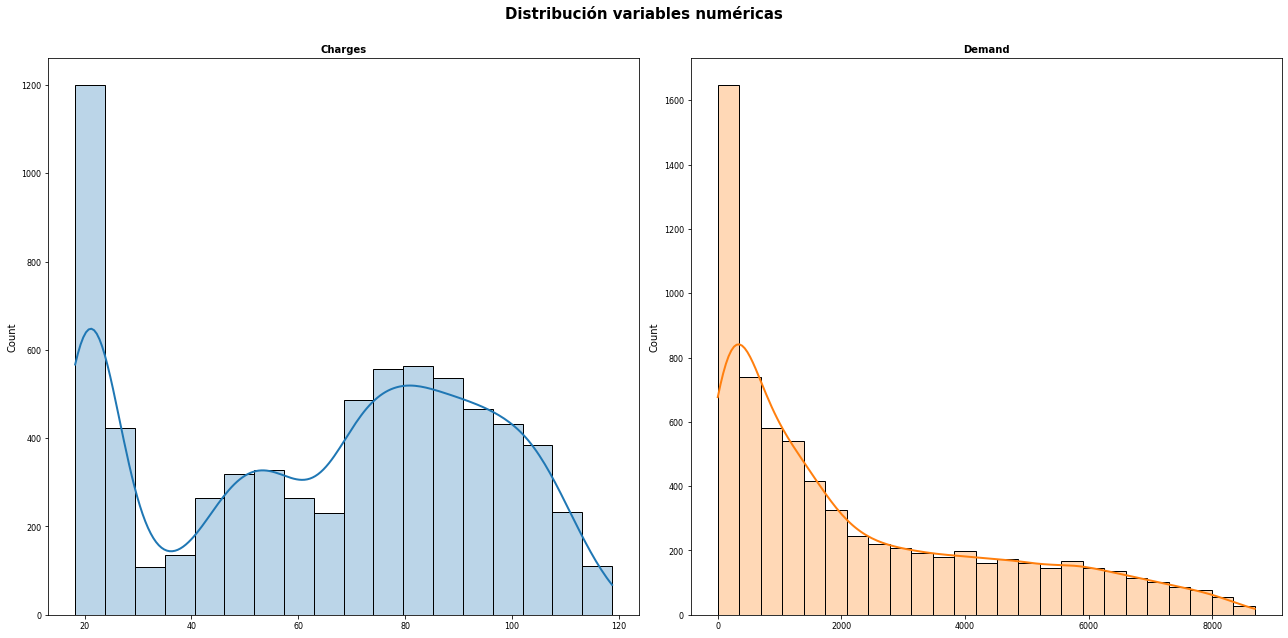

In [17]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))
axes = axes.flat
columnas_numeric = datos.select_dtypes(include=['float64']).columns

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = datos,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 8)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 15, fontweight = "bold");

In [18]:
# Correlación entre columnas numéricas
# ==============================================================================

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)



corr_matrix = datos.select_dtypes(include=['float64']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
1,Charges,Demand,0.651174,0.651174
2,Demand,Charges,0.651174,0.651174


In [19]:
# Variables cualitativas (tipo object)
# ==============================================================================
datos.select_dtypes(include=['object']).describe()

,autoID,SeniorCity,Partner,Dependents,Service1,Service2,Security,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,Class
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,2,4,2
top,7590-VHVEG,0,No,No,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,Alpha
freq,1,5901,3641,4933,6361,3390,3498,3088,3095,3473,3875,4171,2365,5174


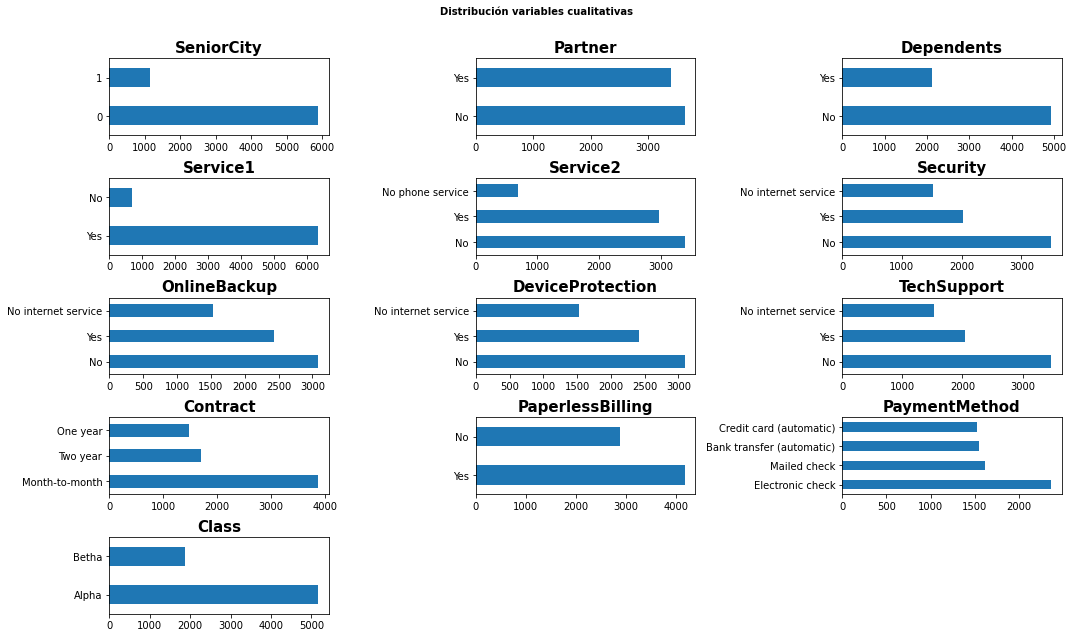

In [21]:
# Gráfico para cada variable cualitativa
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 9))
axes = axes.flat
columnas_category = datos.select_dtypes(include=['object']).columns[1:]

for i, colum in enumerate(columnas_category):
    datos[colum].value_counts().plot.barh(ax = axes[i])
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 10)
    axes[i].set_xlabel("")

# Se eliminan los axes vacíos
for i in [13,14]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables cualitativas',
             fontsize = 10, fontweight = "bold");

# **Preprocesamiento datos**

In [22]:
#convertir variables objetivo en categorica
datos['Class_y'] = pd.get_dummies(datos['Class'], drop_first = True)

In [23]:
#asignar dataframe de caracteristicas
X = datos.drop(['autoID','Class','Class_y'], axis = 'columns')
#asignar variable objetivo
y = datos["Class_y"]
#semilla para mantener resultados
seed=10

In [24]:
y.value_counts()

0    5174
1    1869
Name: Class_y, dtype: int64

In [25]:
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.to_list()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.to_list()

# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[
                            ('scaler', StandardScaler())
                        ]
                      )


# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[
                                ('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))
                            ]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )


In [30]:
_X=preprocessor.fit_transform(X)

In [32]:
# #aplicar transformaciones a  dataset, convertir en dataframe y añadir el nombre de las columnas
# ==============================================================================

encoded_cat = preprocessor.named_transformers_['cat']['onehot']\
              .get_feature_names(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])
X_prep = preprocessor.transform(X)
X_prep = pd.DataFrame(X_prep, columns=labels)
X_prep.head()

,Charges,Demand,SeniorCity_1,Partner_Yes,Dependents_Yes,Service1_Yes,Service2_No,Service2_No phone service,Service2_Yes,Security_No,...,TechSupport_No internet service,TechSupport_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-1.160323,-0.992611,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-0.259629,-0.172165,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.362660,-0.958066,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,-0.746535,-0.193672,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.197365,-0.938874,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [33]:
df = pd.concat([pd.DataFrame(X_prep), pd.DataFrame(y)], axis=1,)
df.head()

,Charges,Demand,SeniorCity_1,Partner_Yes,Dependents_Yes,Service1_Yes,Service2_No,Service2_No phone service,Service2_Yes,Security_No,...,TechSupport_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Class_y
0,-1.160323,-0.992611,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
1,-0.259629,-0.172165,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,-0.362660,-0.958066,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
3,-0.746535,-0.193672,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0
4,0.197365,-0.938874,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1


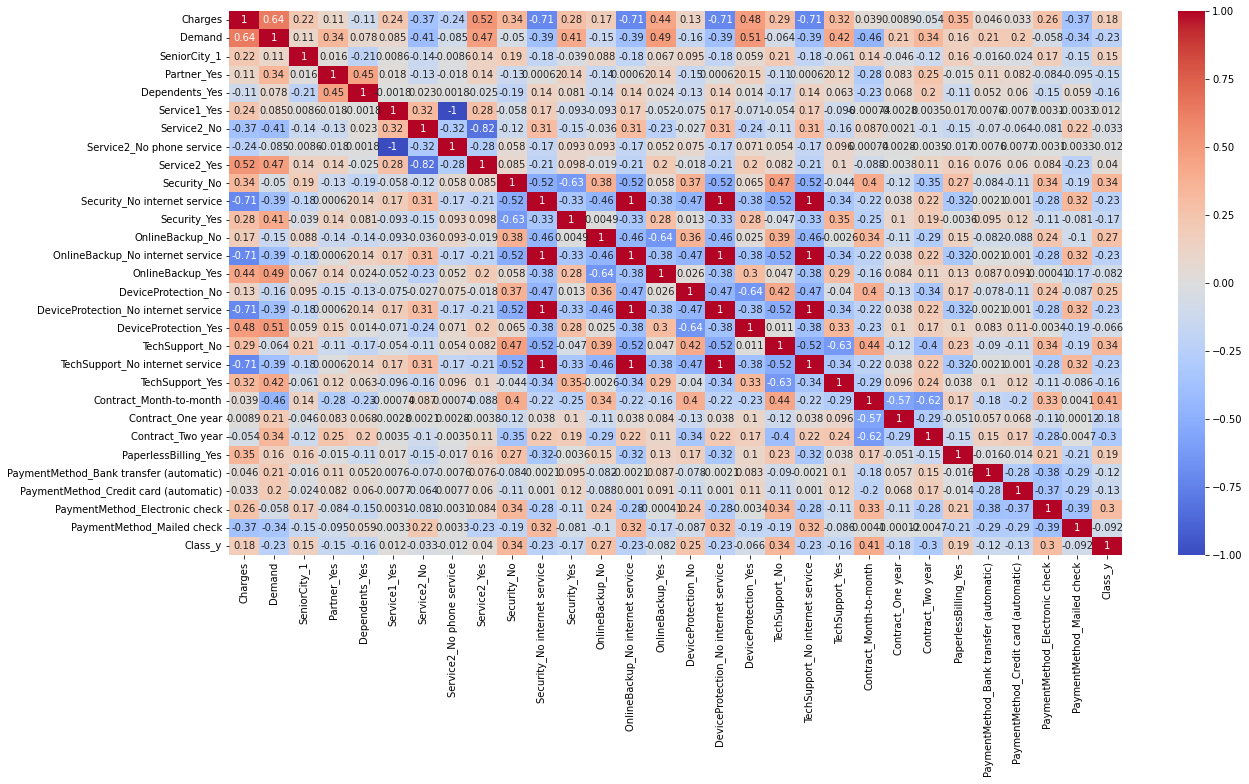

In [34]:
#correlacion variables
corr = df.corr(method='spearman')
ax , fig  = plt.subplots(figsize =(20 , 10 ))
sns.heatmap(corr ,vmin = -1 , cmap='coolwarm', annot = True)
plt.show()

In [35]:
#balancear dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X_prep, y)

In [36]:
df_balanceado = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis=1,)
df_balanceado.head()

,Charges,Demand,SeniorCity_1,Partner_Yes,Dependents_Yes,Service1_Yes,Service2_No,Service2_No phone service,Service2_Yes,Security_No,...,TechSupport_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Class_y
0,-1.160323,-0.992611,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
1,-0.259629,-0.172165,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,-0.362660,-0.958066,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
3,-0.746535,-0.193672,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0
4,0.197365,-0.938874,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1


In [37]:
df_balanceado.Class_y.value_counts()

0    5174
1    5174
Name: Class_y, dtype: int64

In [38]:
#eliminar columnas dependientes
df_balanceado.drop(['TechSupport_No internet service','DeviceProtection_No internet service', 'OnlineBackup_No internet service'], axis = 'columns', inplace=True)

In [39]:
# Reparto de datos en train y test
# ==============================================================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                        df_balanceado.drop(['Class_y'], axis = 'columns'),
                                        df_balanceado['Class_y'],
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True,
                                        stratify=y
                                    )

In [40]:
y_test.value_counts()

1    1035
0    1035
Name: Class_y, dtype: int64

In [41]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8278 entries, 1459 to 8258
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Charges                                  8278 non-null   float64
 1   Demand                                   8278 non-null   float64
 2   SeniorCity_1                             8278 non-null   float64
 3   Partner_Yes                              8278 non-null   float64
 4   Dependents_Yes                           8278 non-null   float64
 5   Service1_Yes                             8278 non-null   float64
 6   Service2_No                              8278 non-null   float64
 7   Service2_No phone service                8278 non-null   float64
 8   Service2_Yes                             8278 non-null   float64
 9   Security_No                              8278 non-null   float64
 10  Security_No internet service             8278

# **Modelo de regresion logistica, busqueda de hiperparametros (mejor c) con validacion cruzada**

In [42]:
# Grid de hiperparámetros
# ==============================================================================
param_grid = {'C': np.logspace(-5, 7, 20)}

# Búsqueda por validación cruzada
# ==============================================================================


grid = GridSearchCV(
        estimator  = LogisticRegression(penalty='l2',random_state=seed,solver="newton-cg",class_weight="balanced"),
        param_grid = param_grid,
        scoring    ='precision' , #'accuracy','precision', 'recall'
        n_jobs     = -1,
        cv         = 5, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5)

,param_C,mean_test_score,std_test_score,mean_train_score,std_train_score
8,1.128838,0.751994,0.009670,0.754534,0.001456
19,10000000.0,0.751936,0.008872,0.754751,0.001459
11,88.586679,0.751936,0.008872,0.754751,0.001459
18,2335721.46909,0.751936,0.008872,0.754751,0.001459
17,545559.478117,0.751936,0.008872,0.754751,0.001459


In [43]:
#mejor modelo encontrado
modelo_rl = grid.best_estimator_
modelo_rl

LogisticRegression(C=1.1288378916846884, class_weight='balanced',
                   random_state=10, solver='newton-cg')

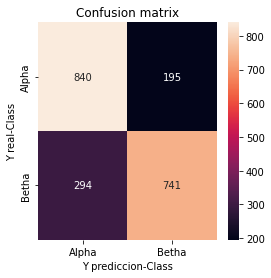

              precision    recall  f1-score   support

           0       0.79      0.72      0.75      1035
           1       0.74      0.81      0.77      1035

    accuracy                           0.76      2070
   macro avg       0.77      0.76      0.76      2070
weighted avg       0.77      0.76      0.76      2070



In [44]:
#definimos funcion para mostrar los resultados
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y,labels=[1,0])
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_matrix, xticklabels=["Alpha","Betha"], yticklabels=["Alpha","Betha"], annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('Y real-Class')
    plt.xlabel('Y prediccion-Class')
    plt.show()
    print (classification_report(y_test, pred_y))
 
pred_y = modelo_rl.predict(X_test)
mostrar_resultados(y_test, pred_y)

# **Maquina de vector soporte**

In [45]:
svm_model=SVC(random_state=seed, class_weight='balanced').fit(X_train,y_train)
pred_y=svm_model.predict(X_test)
accuracy_score(y_test,pred_y)

0.7710144927536232

In [47]:
# Grid de hiperparámetros
# ==============================================================================
param_grid = {'C':  np.logspace(-3, 5, 5)}#, 'kernel': ('poly', 'rbf')} #"gamma": [0.001, 0.01, 0.1, 1]

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = SVC(gamma='scale'),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 5, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5)

,param_C,mean_test_score,std_test_score,mean_train_score,std_train_score
2,10.0,0.820369,0.011119,0.869594,0.002402
3,1000.0,0.817832,0.015488,0.936972,0.001931
4,100000.0,0.797056,0.013725,0.955786,0.001050
1,0.1,0.766127,0.010839,0.770718,0.002824
0,0.001,0.699664,0.075798,0.704070,0.075626


In [48]:
modelo_svc = grid.best_estimator_
modelo_svc

SVC(C=10.0)

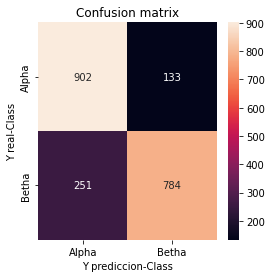

              precision    recall  f1-score   support

           0       0.85      0.76      0.80      1035
           1       0.78      0.87      0.82      1035

    accuracy                           0.81      2070
   macro avg       0.82      0.81      0.81      2070
weighted avg       0.82      0.81      0.81      2070



In [49]:
pred_y = modelo_svc.predict(X_test)
mostrar_resultados(y_test, pred_y)

# **arbol de decision clasificacion**

In [50]:
# Grid de hiperparámetros
# ==============================================================================
param_grid = {"max_depth":list(range(1,10)),"min_samples_split":list(range(2,50))}

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = tree.DecisionTreeClassifier(random_state=seed),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 5, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5)

,param_max_depth,param_min_samples_split,mean_test_score,std_test_score,mean_train_score,std_train_score
384,9,2,0.784855,0.014370,0.856427,0.000529
387,9,5,0.784492,0.014227,0.855037,0.000929
386,9,4,0.784251,0.014904,0.855702,0.000786
388,9,6,0.784250,0.013980,0.854252,0.001030
385,9,3,0.784130,0.014303,0.855944,0.000868


In [51]:
modelo_Tree = grid.best_estimator_
modelo_Tree

DecisionTreeClassifier(max_depth=9, random_state=10)

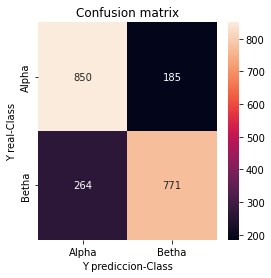

              precision    recall  f1-score   support

           0       0.81      0.74      0.77      1035
           1       0.76      0.82      0.79      1035

    accuracy                           0.78      2070
   macro avg       0.78      0.78      0.78      2070
weighted avg       0.78      0.78      0.78      2070



In [52]:
pred_y = modelo_Tree.predict(X_test)
mostrar_resultados(y_test, pred_y)

# **Random Forest**

In [53]:
rf_model=RandomForestClassifier(random_state=seed).fit(X_train,y_train)
y_pred=rf_model.predict(X_test)
accuracy_score(y_test,y_pred)

0.8357487922705314

In [54]:
# Grid de hiperparámetros
# ==============================================================================
param_grid = {"max_depth":[2,5,8,10], "max_features":[2,5,8], "n_estimators":[10,500,1000],"min_samples_split":[2,5,10]}

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = RandomForestClassifier(random_state=seed),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 5, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5)

,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
103,10,8,5,500,0.831604,0.011458,0.888772,0.002401
101,10,8,2,1000,0.831483,0.012003,0.895416,0.002332
100,10,8,2,500,0.829912,0.012063,0.895023,0.002460
104,10,8,5,1000,0.829550,0.012226,0.889678,0.002543
107,10,8,10,1000,0.828704,0.012043,0.881463,0.002553


In [55]:
modelo_rf = grid.best_estimator_
modelo_rf

RandomForestClassifier(max_depth=10, max_features=8, min_samples_split=5,
                       n_estimators=500, random_state=10)

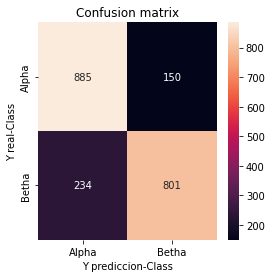

              precision    recall  f1-score   support

           0       0.84      0.77      0.81      1035
           1       0.79      0.86      0.82      1035

    accuracy                           0.81      2070
   macro avg       0.82      0.81      0.81      2070
weighted avg       0.82      0.81      0.81      2070



In [56]:
pred_y = modelo_rf.predict(X_test)
mostrar_resultados(y_test, pred_y)

# **Grafico comparativo de modelos**

<AxesSubplot:xlabel='Accuracy', ylabel='Modelos'>

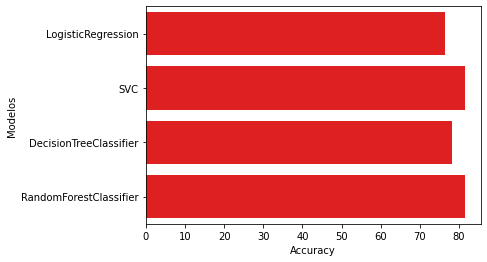

In [57]:
modelos=[modelo_rl, modelo_svc,modelo_Tree, modelo_rf]
result=[]
resultados=pd.DataFrame(columns=["Modelos","Accuracy"])

for model in modelos:
    names=model.__class__.__name__
    y_pred=model.predict(X_test)
    accuracy=accuracy_score(y_test,y_pred)
    result=pd.DataFrame([[names,accuracy*100]],columns=["Modelos","Accuracy"])
    resultados=resultados.append(result)
    
results = resultados.sort_values('Accuracy').reset_index()

sns.barplot(x="Accuracy",y="Modelos",data=resultados,color="r")

# **Serializar modelo seleccionado**

In [58]:
import pickle
pickle_out = open("classifier.pkl","wb")
pickle.dump(modelo_rf, pickle_out)
pickle_out.close()

In [64]:
from joblib import dump
dump(preprocessor, 'preprocessor.joblib') 

['preprocessor.joblib']

In [66]:
dump(modelo_rf, 'modelo_clasificador.joblib')

['modelo_clasificador.joblib']